# Free Lunch (there is such a thing!)
Working with NYC DOE to develope a method to optimize school lunch and breakfast reimbursements from the federal governement (USDA).

###Overview
The Community Eligibility Provision (CEP) is program aimed at streamlining reimbursement claims. It requires that participating schools provide universal breakfast and lunch service, where all meals are served at no cost to the students.

###Reimbursement Rules:
Schools get reimbursed at either the "free" rate or the "paid" rate for each meal. (Other programs have an additional "reduced" rate, but that does not apply here). The fraction of meals that get reimbursed at the "free" rate is determined by the group the school is enrolled under. This fraction we will call the "threshold". The rest of the meals get reimbursed at the "paid" rate. 


$$\begin{align}
Reimbursements = \sum_{s} threshold_s [(r_{l,free} - r_{l,paid}) L_s  + 
                                (r_{b,free} - r_{b,paid})  B_s] 
                                + r_{l,paid} L_s + r_{b,paid} B_s
\end{align}$$




Before the school year begins the thresholds for each school are set and are based on the group, $g$, the school is enrolled in. The threshold is based on the number of "identified students" $I_g$ and the total number of students $N_g$ in the group. Where these numbers are based on enrollment in the previous school.
$$
\begin{equation*}
threshold = Min (1, I_g/N_g * multiplier)   
\end{equation*}
$$

###Grouping Rules
* All groups have to meet the minimum threshold: $threshold_{min} = .40$
* There can be at most 9 (?) groups

###Objective
Find the optimum groupings to maximize reimbursement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#constants

multiplier = 1.6

# meal reimbursement rates
freeLunch = 3.16
paidLunch = 1.71
freeBreakfast = 2.04
paidBreakfast = .29

deltaLunchRate = freeLunch - paidLunch
deltaBreakfastRate = freeBreakfast - paidBreakfast 

In [12]:
# this part is made up data from cep website
cep = pd.read_excel("cep-database-excel-file.xlsx")
nycep = cep[(cep.State=='New York')&(cep['Participation in Community Eligibility Provision 2016-2017']=='Y')]

# putting made up data into correct form
#school = nycep[['School','Identified Student Percentage (ISP)','Enrollment']].copy()
# for testing use a random sample of full dataset
school = nycep[['School','Identified Student Percentage (ISP)','Enrollment']].sample(100,random_state=101)

school.rename(columns={'Identified Student Percentage (ISP)':'ISP',
                      'School':'Name'},inplace=True)
school.reset_index(inplace=True)

school['Identified']=(school['ISP']*school['Enrollment']).astype(float).round()
np.random.seed(42)
school['LunchPerStudent'] = np.random.random(school.shape[0])
school['BreakfastPerStudent'] = np.random.random(school.shape[0])
daysperyear = 180
school['Lunches'] =(school['LunchPerStudent']*school['Enrollment']*daysperyear).astype(float).round()
school['Breakfasts'] =(school['BreakfastPerStudent']*school['Enrollment']*daysperyear).astype(float).round()

school['meal'] = deltaLunchRate*school['Lunches'] + deltaBreakfastRate*school['Breakfasts']
school['meal/student'] = school['meal']/school['Enrollment']
school['baseThreshold'] = school['Identified']/school['Enrollment']*multiplier


# trimming out high thresholds to make for a harder problem
school = school[school.baseThreshold<1]
school.reset_index(inplace=True,drop=True)


print school.shape
school.head()

(49, 12)


,index,Name,ISP,Enrollment,Identified,LunchPerStudent,BreakfastPerStudent,Lunches,Breakfasts,meal,meal/student,baseThreshold
0,30044,IS 349 MATH SCIENCE & TECHNOLOGY,0.52312,520,272.0,0.374540,0.031429,35057.0,2942.0,55981.15,107.656,0.836923
1,29035,BETH RIVKAH HIGH SCHOOL,0.5721,559,320.0,0.598658,0.508571,60237.0,51172.0,176894.65,316.448,0.915921
2,29970,EAST FLATBUSH COMMUNITY RESEARCH SCHOOL,0.589691,50,29.0,0.156019,0.907566,1404.0,8168.0,16329.80,326.596,0.928
3,30252,PRE-K CENTER AT 68-10 CENTRAL AVENUE,0.555,118,65.0,0.058084,0.410383,1234.0,8717.0,17044.05,144.441,0.881356
4,29940,BRONX GUILD HIGH SCHOOL,0.400009,6,2.0,0.832443,0.929698,899.0,1004.0,3060.55,510.092,0.533333


In [13]:
# all meals are reimbursed at a minimum at the paid rate
# the base reimbursement is independant of groupings and is equal to 
# the lowest reimbursements rates (i.e. "paid" rates) times the total number of each meal
baseReimburse = paidLunch*school.Lunches.sum() + paidBreakfast*school.Breakfasts.sum()

# reimbursements over the base, this is the part that's dependant on groupings
def calcReimburse(df,result):
    ''' 
    calculates the reimbursements per school. 
    Each row in df is a school.
    Updates df to include  'threshold' (based on groups) and 'reimburse' columns.
    Results stored in results list
    ''' 
    # calc threshold. threshold can be greater than 1 because of multiplier.
    for i in set(df.group):
        dfgrp = df[df.group==i].copy()
        identified = dfgrp['Identified'].sum()
        students = dfgrp['Enrollment'].sum()
        df.loc[df.group == i,'threshold'] = identified / float(students) * multiplier
    
    # based on threshold, calculate group reimbursement
    df['reimburse'] = df['meal']*(df['threshold'].apply(lambda x: min(x,1)))

    # store 'results' as a list of lists. 
    #     The inner lists 0th item saves info about the groupings,
    #     the 1st item is the number of groups
    #     the 2nd item is the reimbusement (above base reimbursement)
    #     the 3rd item is whether or not the threshold has been met for the goups
    if df['threshold'].min() >= .40*multiplier:
        result.append([df[['group','threshold','meal']].copy(),len(set(df.group)),
                        df.reimburse.sum(),'threshold met'])
    else:
        result.append([df[['group','threshold','meal']].copy(),len(set(df.group)),
                       df.reimburse.sum(),'threshold not met'])
    return result

def groupReimburse(df):
    '''given a dataframe df, assuming all rows are in the same 'group', this calculates the
    reimbursements for the full group'''
    td = (df['Identified'].sum()) / float(df['Enrollment'].sum())*multiplier
    ml = df['meal'].sum() 
    return (ml)*min(td,1)

def groupThreshold(df):
    '''given a dataframe df, assuming all rows are in the same 'group', this calculates the
    'threshold' for the full group'''
    return (df['Identified'].sum()) / float(df['Enrollment'].sum())*multiplier
    

def deltaReimburse(df,group1,group2):
    '''difference in reimbursement with combining groups vs separate'''
    df12 = df[(df['group'] == group1)|(df['group'] == group2)].copy()
    r12 = groupReimburse(df12)

    df1 = df[df['group'] == group1].copy()
    r1 = groupReimburse(df1)
     
    df2 = df[df['group'] == group2].copy()
    r2 = groupReimburse(df2)

    return r12 - r1 - r2

In [14]:
t0 = groupThreshold(school)
t0

0.9066949438473032

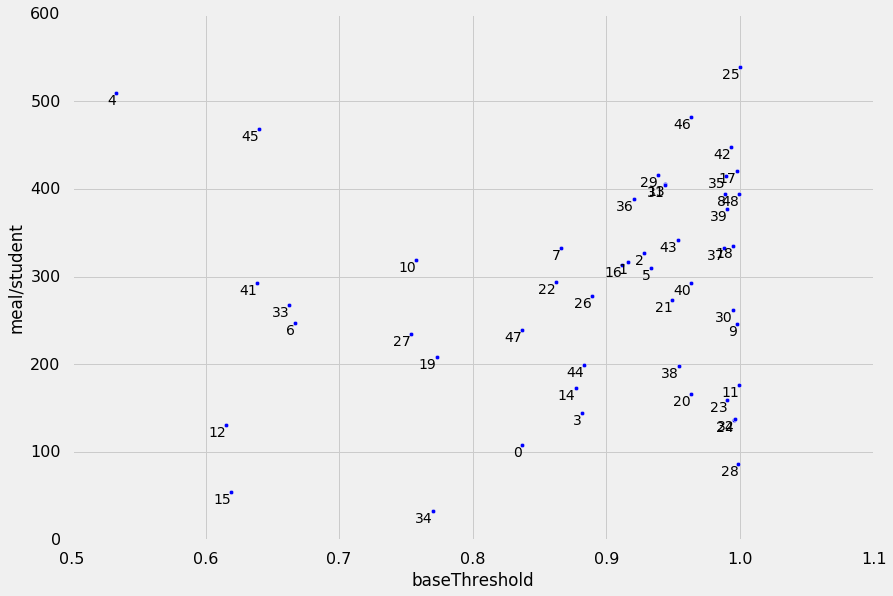

In [15]:
ax = school.plot.scatter(x='baseThreshold',y='meal/student')
for i in school.index:
    ax.annotate(i,xy=(school.loc[i]['baseThreshold'],school.loc[i]['meal/student']),ha='right',va='top')

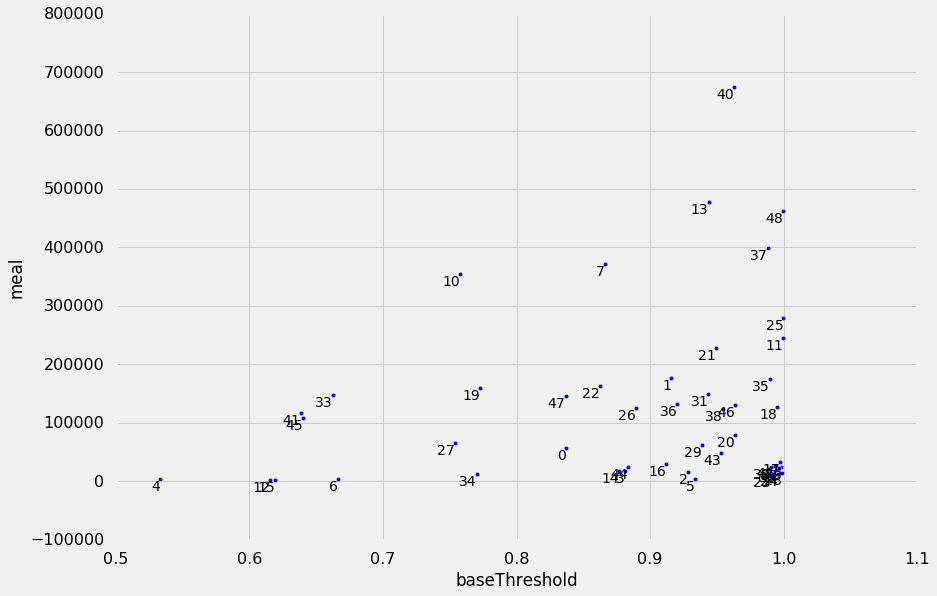

In [16]:
ax = school.plot.scatter(x='baseThreshold',y='meal')
for i in school.index:
    ax.annotate(i,xy=(school.loc[i]['baseThreshold'],school.loc[i]['meal']),ha='right',va='top')

In [17]:
#initializing results as a list. This is where the groupings and reimbursements will be stored
results = []
tempResults = [] #throw away results

# this implementation of threshold only for each school separately
# each school is it's own group to start with
school['group']=school.index
calcReimburse(school, results)

[[    group  threshold       meal
  0       0   0.836923   55981.15
  1       1   0.915921  176894.65
  2       2   0.928000   16329.80
  3       3   0.881356   17044.05
  4       4   0.533333    3060.55
  5       5   0.933333    3721.05
  6       6   0.666667    2963.85
  7       7   0.865950  371141.70
  8       8   0.989091   21663.20
  9       9   0.998020   24836.50
  10     10   0.757668  355324.70
  11     11   0.999278  244342.90
  12     12   0.615385    1694.15
  13     13   0.943729  478306.60
  14     14   0.876923   17993.25
  15     15   0.619355    1697.10
  16     16   0.911828   29090.35
  17     17   0.997403   32417.20
  18     18   0.994709  126638.10
  19     19   0.772917  160167.35
  20     20   0.963333   79491.45
  21     21   0.949282  228535.95
  22     22   0.862432  162039.00
  23     23   0.990476   10012.00
  24     24   0.995556   12242.25
  25     25   0.999613  278748.75
  26     26   0.889286  124441.65
  27     27   0.753957   65280.10
  28     28   

In [18]:
print 'base', "{:.2E}".format(baseReimburse)
possReimb = [x[2] for x in results]
print 'above base', "{:.2E}".format(max(possReimb))

base 3.27E+06
above base 5.59E+06


In [19]:
# put all schools in one group
school['group']=0
calcReimburse(school, results)
"{:.2e}".format(results[-1][2])

'5.55e+06'

In [20]:
l0=school.meal.sum()/school.Enrollment.sum()
l0

294.8386923410614

In [21]:
possReimb = [x[2] for x in results]
print 'saved', "{:.2E}".format(max(possReimb)-min(possReimb))
print 'max', possReimb.index(max(possReimb))
print 'min', possReimb.index(min(possReimb))

saved 3.95E+04
max 0
min 1


In [11]:
# random
numberOfGroups = 5
school['group'] = school[:numberOfGroups].sample(school.shape[0],replace=True).index
results = calcReimburse(school, results)

possReimb = [x[2] for x in results]
print 'saved', "{:.2E}".format(max(possReimb)-min(possReimb))
print 'max', possReimb.index(max(possReimb))
print 'min', possReimb.index(min(possReimb))

saved 6.86E+05
max 1
min 0


## Grouping by two

In [33]:
#initialize deltaR
school['group']=school.index
calcReimburse(school,tempResults)
index = list(set(school.group))
deltaR = pd.DataFrame(0,columns=index,index=index)

for i in index:
    for j in index:
        if i < j: #can probably optimize this
            deltaR.loc[i,j] = deltaReimburse(school,i,j)


while (deltaR.values.max() > 0):
    # the max value of deltaR, if it's >0, determines the groups to be combined
    # if max is <=0 then no further combination will increase reimbursements
    
    # the index and column location of the max value
    indLoc = np.where(deltaR == deltaR.values.max())[0][0] 
    colLoc = np.where(deltaR == deltaR.values.max())[1][0]
    
    # the index location corresponds to the first group, the column location to the second group
    # note the firstGroup number is smaller than the secondGroup.
    firstGroup = index[indLoc]
    secondGroup = index[colLoc]
    
    #drop the row/col of the second group in deltaR (it will be combined with the first group)
    deltaR.drop(secondGroup,axis=0, inplace=True)
    deltaR.drop(secondGroup,axis=1,inplace=True)
    
    #combining groups in the school df
    school.loc[school.group==secondGroup,'group']=firstGroup
    
    #reset index
    index = list(set(school.group))
    #loop through the row of deltaR corresponding to the new grouping
    for i in index:
        if i>firstGroup:
            deltaR.loc[firstGroup,i] = deltaReimburse(school,firstGroup,i)

results = calcReimburse(school, results)
deltaR

,0,1,3,5,8,42
0,0,-36688.611949,-10790.124716,-254.917040,-2524.876094,-3385.280927
1,0,0.000000,-14240.378816,-3561.128703,-156.613956,-732.534121
3,0,0.000000,0.000000,-60.226523,-1058.555324,-1542.579093
5,0,0.000000,0.000000,0.000000,-546.331914,-11034.115784
8,0,0.000000,0.000000,0.000000,0.000000,-6.114511
42,0,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
results

[[    group  threshold       meal
  0       0   0.836923   55981.15
  1       1   0.915921  176894.65
  2       2   0.928000   16329.80
  3       3   0.881356   17044.05
  4       4   0.533333    3060.55
  5       5   0.933333    3721.05
  6       6   0.666667    2963.85
  7       7   0.865950  371141.70
  8       8   0.989091   21663.20
  9       9   0.998020   24836.50
  10     10   0.757668  355324.70
  11     11   0.999278  244342.90
  12     12   0.615385    1694.15
  13     13   0.943729  478306.60
  14     14   0.876923   17993.25
  15     15   0.619355    1697.10
  16     16   0.911828   29090.35
  17     17   0.997403   32417.20
  18     18   0.994709  126638.10
  19     19   0.772917  160167.35
  20     20   0.963333   79491.45
  21     21   0.949282  228535.95
  22     22   0.862432  162039.00
  23     23   0.990476   10012.00
  24     24   0.995556   12242.25
  25     25   0.999613  278748.75
  26     26   0.889286  124441.65
  27     27   0.753957   65280.10
  28     28   

In [78]:
possReimb = [x[2] for x in results]
print 'saved', "{:.2E}".format(max(possReimb)-min(possReimb))
print 'max', possReimb.index(max(possReimb))
print 'min', possReimb.index(min(possReimb))

saved 7.96E+04
max 3
min 1


In [79]:
[x[2] for x in results]

[5585744.8003755854,
 5546269.6093661739,
 5560296.6941264784,
 5625860.1028425461]

## ungrouping by two

In [23]:
ttarget = 1
tlowerbound = .4*1.6

#start with everyschool in the same group
school.group = 0
t0 = groupThreshold(school)

#check to see if t0 is within bounds
if (t0<tlowerbound):
    print 'error - schools dont qualify'
if (t0>=ttarget):
    print 'done - cant do better than that!'
print 't0 =',t0

t0= 0.906694943847


In [24]:
school.group = 0
t0 = groupThreshold(school)

df = school.copy()
ungroup = []

while(t0<ttarget):
    index = df[(df.baseThreshold<t0)&(df.baseThreshold>tlowerbound)].index
    deltaR = pd.Series(0,index=index)

    for i in index:
        df.group = 0
        df.loc[i,'group'] = 1
        deltaR.loc[i] = deltaReimburse(df,1,0)
    
    if (deltaR.min()<0):
        ungroup.append(deltaR.idxmin())
        df.drop(deltaR.idxmin(),inplace=True)
        t0 = groupThreshold(df)
    else:
        break

print t0
ungroup

0.935304281052


[34, 19, 0, 33, 47, 27, 3, 14, 22, 26, 44, 6, 1, 16, 5]

In [31]:
school.group=school.index
school.loc[~school.index.isin(ungroup),'group']=1000
calcReimburse(school,results)

[[    group  threshold       meal
  0       0   0.836923   55981.15
  1       1   0.915921  176894.65
  2       2   0.928000   16329.80
  3       3   0.881356   17044.05
  4       4   0.533333    3060.55
  5       5   0.933333    3721.05
  6       6   0.666667    2963.85
  7       7   0.865950  371141.70
  8       8   0.989091   21663.20
  9       9   0.998020   24836.50
  10     10   0.757668  355324.70
  11     11   0.999278  244342.90
  12     12   0.615385    1694.15
  13     13   0.943729  478306.60
  14     14   0.876923   17993.25
  15     15   0.619355    1697.10
  16     16   0.911828   29090.35
  17     17   0.997403   32417.20
  18     18   0.994709  126638.10
  19     19   0.772917  160167.35
  20     20   0.963333   79491.45
  21     21   0.949282  228535.95
  22     22   0.862432  162039.00
  23     23   0.990476   10012.00
  24     24   0.995556   12242.25
  25     25   0.999613  278748.75
  26     26   0.889286  124441.65
  27     27   0.753957   65280.10
  28     28   

In [32]:
school.group=0
school.loc[~school.index.isin(ungroup),'group']=1000
calcReimburse(school,results)

[[    group  threshold       meal
  0       0   0.836923   55981.15
  1       1   0.915921  176894.65
  2       2   0.928000   16329.80
  3       3   0.881356   17044.05
  4       4   0.533333    3060.55
  5       5   0.933333    3721.05
  6       6   0.666667    2963.85
  7       7   0.865950  371141.70
  8       8   0.989091   21663.20
  9       9   0.998020   24836.50
  10     10   0.757668  355324.70
  11     11   0.999278  244342.90
  12     12   0.615385    1694.15
  13     13   0.943729  478306.60
  14     14   0.876923   17993.25
  15     15   0.619355    1697.10
  16     16   0.911828   29090.35
  17     17   0.997403   32417.20
  18     18   0.994709  126638.10
  19     19   0.772917  160167.35
  20     20   0.963333   79491.45
  21     21   0.949282  228535.95
  22     22   0.862432  162039.00
  23     23   0.990476   10012.00
  24     24   0.995556   12242.25
  25     25   0.999613  278748.75
  26     26   0.889286  124441.65
  27     27   0.753957   65280.10
  28     28   

## find max/min threshold for all schools
set the max threshold at the school that has the greatest difference between min/max possible reimbursements.
recalculate min/max thresholds with remaining schools and repeat

In [207]:
def calcBounds(sminmax):
    '''calculate upper and lower bounds to reimbursements'''
    sminmax['group'] = sminmax.index
    tempResults = []
    calcReimburse(sminmax,tempResults)     
    for i in sminmax.index.values:
        sminmax.group = sminmax.index
        #define tgroup to hold original threshold values, drop one by one highest to lowest
        tgroup = sminmax.threshold.copy()
        # initialize the new threshold
        newt = sminmax.loc[i].threshold 
        while (newt < tgroup.max()) and (newt<1):
            #combine the group with the maximum threshold with group i
            #calculate the new threshold of that combined group
            #new indicies to include in threshold calculation
            newIndex = tgroup[tgroup==tgroup.max()].index
            dftemp = sminmax[(sminmax.group==i)|\
                             (sminmax.index.isin(newIndex))].copy()
            #calculate new threshold
            newnewt = dftemp['Identified'].sum() / float(dftemp['Enrollment'].sum())*multiplier
            if newnewt<1:
                #only save this group if the new value of the threshold is<1
                sminmax.loc[newIndex,'group']=i
                # drop tmax from group and start over
                tgroup.drop(newIndex,inplace=True)
                newt=newnewt
            else:
                break
        #store the max threshold tmax, and the groupings that made it gmax.
        sminmax.loc[i,'tmax'] = newt
        sminmax.loc[i,'gmax'] = ','.join(str(x) for x in (sminmax[sminmax.group==i].index.values))
    
    sminmax['rmax'] = sminmax['meal']*(sminmax['tmax'].apply(lambda x:min(x,1)))
    sminmax['rover'] = sminmax['meal']*sminmax['tmax'] - sminmax['rmax']

    #calculate lower bound to reimbursement
    for i in sminmax.index.values:
        # set to individual groups (thesholds already set above)
        sminmax.group = sminmax.index
    
        #define tgroup to hold original threshold values, drop one by one highest to lowest
        tgroup = sminmax.threshold.copy()
        # initialize the new threshold
        newt = sminmax.loc[i].threshold 
        while (newt > tgroup.min()):
            #combine the group with the minimum threshold with group i
            sminmax.loc[tgroup[tgroup==tgroup.min()].index,'group']=i
            #calculate the new threshold of that combined group
            dftemp = sminmax[sminmax.group==i].copy()
            newt = dftemp['Identified'].sum() / float(dftemp['Enrollment'].sum())*multiplier
            # drop tmin from group and start over
            tgroup.drop(tgroup[tgroup==tgroup.min()].index,inplace=True)
        #store the min threshold tmin, and the groupings that made it gmin.
        sminmax.loc[i,'tmin'] = newt
        sminmax.loc[i,'gmin'] = ','.join(str(x) for x in (sminmax[sminmax.group==i].index.values))

    sminmax['rmin'] = sminmax['meal']*(sminmax['tmin'].apply(lambda x:min(x,1)))
    
    sminmax['rmax-rmin'] = sminmax['rmax'] - sminmax['rmin']
    sminmax['rmax-rmin-rover'] = sminmax['rmax-rmin'] - sminmax['rover']
    sminmax['rmax-r'] = sminmax['rmax'] - sminmax['reimburse']


In [227]:
sbounds = school[['Name','Enrollment','Identified','Lunches',
               'Breakfasts','group']].copy()
calcBounds(sbounds)

print "{:2e}".format(sbounds.rmax.sum())

8.405688e+06


In [213]:
sbounds[['gmax','rmax','reimburse','rmax-rmin']].sort_values('rmax-rmin')

,gmax,rmax,reimburse,rmax-rmin
94,94,1971.432727,1971.432727,0.000000
46,46,2625.060000,2625.060000,32.408148
71,71,456.700000,456.700000,36.924681
34,34,2636.070000,2636.070000,46.246842
57,57,930.528000,930.528000,58.158000
91,91,5250.435556,5250.435556,155.673291
90,90,678.461538,678.461538,174.681690
14,14,4741.696000,4741.696000,182.372923
26,26,2478.133333,2478.133333,200.359716
82,82,4833.728000,4833.728000,219.714909


In [228]:
# set the groups in order of the largest reimbursement difference (rmax-rmin)
school.group = school.index
sbound = school[['Name','Enrollment','Identified','Lunches',
               'Breakfasts','meal','group','threshold']].copy()

while(sbound.shape[0]>0):
    calcBounds(sbound)
    indexMax = sbound['rmax-rmin'].idxmax()
    groupList = map(int,sbound.loc[indexMax].gmax.split(','))
    school.loc[school.index.isin(groupList),'group'] = min(groupList)
    #drop all schools already set
    sbound.drop(groupList,inplace=True)    

calcReimburse(school,results)
results

[[    group  threshold       meal
  0       0   1.263158   22499.00
  1       1   0.639696  472380.85
  2       2   0.870777  216394.40
  3       3   1.096447  124681.65
  4       4   0.940741   70546.20
  5       5   1.009929   33625.60
  6       6   0.810782  214333.50
  7       7   0.993103   26916.35
  8       8   1.513357   63423.40
  9       9   0.994595   15470.15
  10     10   0.898385   77799.10
  11     11   0.980645   94218.45
  12     12   1.000991  720801.60
  13     13   1.195686  201176.00
  14     14   0.640000    7408.90
  15     15   0.872727    7091.95
  16     16   0.757895  132693.95
  17     17   0.865660  298098.15
  18     18   1.192157   20088.75
  19     19   1.000360  136476.30
  20     20   1.024189  140358.25
  21     21   0.858537   39195.85
  22     22   1.005283   93504.45
  23     23   1.000000    6253.50
  24     24   0.993103   16601.65
  25     25   1.131707   41754.80
  26     26   0.666667    3717.20
  27     27   0.982278  192133.80
  28     28   

In [229]:
school.meal.sum()

10620785.85

In [233]:
# set the groups in order of the largest reimbursement difference (rmax-rmin)
school.group = school.index
sbound = school[['Name','Enrollment','Identified','Lunches',
               'Breakfasts','meal','group','threshold']].copy()

while(sbound.shape[0]>0):
    calcBounds(sbound)
    indexMax = sbound['rmax'].idxmax()
    groupList = map(int,sbound.loc[indexMax].gmax.split(','))
    school.loc[school.index.isin(groupList),'group'] = min(groupList)
    #drop all schools already set
    sbound.drop(groupList,inplace=True)    

calcReimburse(school,results)
results

[[    group  threshold       meal
  0       0   1.263158   22499.00
  1       1   0.639696  472380.85
  2       2   0.870777  216394.40
  3       3   1.096447  124681.65
  4       4   0.940741   70546.20
  5       5   1.009929   33625.60
  6       6   0.810782  214333.50
  7       7   0.993103   26916.35
  8       8   1.513357   63423.40
  9       9   0.994595   15470.15
  10     10   0.898385   77799.10
  11     11   0.980645   94218.45
  12     12   1.000991  720801.60
  13     13   1.195686  201176.00
  14     14   0.640000    7408.90
  15     15   0.872727    7091.95
  16     16   0.757895  132693.95
  17     17   0.865660  298098.15
  18     18   1.192157   20088.75
  19     19   1.000360  136476.30
  20     20   1.024189  140358.25
  21     21   0.858537   39195.85
  22     22   1.005283   93504.45
  23     23   1.000000    6253.50
  24     24   0.993103   16601.65
  25     25   1.131707   41754.80
  26     26   0.666667    3717.20
  27     27   0.982278  192133.80
  28     28   

In [231]:
school.group=school.index
calcReimburse(school, results)


[[    group  threshold       meal
  0       0   1.263158   22499.00
  1       1   0.639696  472380.85
  2       2   0.870777  216394.40
  3       3   1.096447  124681.65
  4       4   0.940741   70546.20
  5       5   1.009929   33625.60
  6       6   0.810782  214333.50
  7       7   0.993103   26916.35
  8       8   1.513357   63423.40
  9       9   0.994595   15470.15
  10     10   0.898385   77799.10
  11     11   0.980645   94218.45
  12     12   1.000991  720801.60
  13     13   1.195686  201176.00
  14     14   0.640000    7408.90
  15     15   0.872727    7091.95
  16     16   0.757895  132693.95
  17     17   0.865660  298098.15
  18     18   1.192157   20088.75
  19     19   1.000360  136476.30
  20     20   1.024189  140358.25
  21     21   0.858537   39195.85
  22     22   1.005283   93504.45
  23     23   1.000000    6253.50
  24     24   0.993103   16601.65
  25     25   1.131707   41754.80
  26     26   0.666667    3717.20
  27     27   0.982278  192133.80
  28     28   

In [232]:
school.group=0
calcReimburse(school, results)


[[    group  threshold       meal
  0       0   1.263158   22499.00
  1       1   0.639696  472380.85
  2       2   0.870777  216394.40
  3       3   1.096447  124681.65
  4       4   0.940741   70546.20
  5       5   1.009929   33625.60
  6       6   0.810782  214333.50
  7       7   0.993103   26916.35
  8       8   1.513357   63423.40
  9       9   0.994595   15470.15
  10     10   0.898385   77799.10
  11     11   0.980645   94218.45
  12     12   1.000991  720801.60
  13     13   1.195686  201176.00
  14     14   0.640000    7408.90
  15     15   0.872727    7091.95
  16     16   0.757895  132693.95
  17     17   0.865660  298098.15
  18     18   1.192157   20088.75
  19     19   1.000360  136476.30
  20     20   1.024189  140358.25
  21     21   0.858537   39195.85
  22     22   1.005283   93504.45
  23     23   1.000000    6253.50
  24     24   0.993103   16601.65
  25     25   1.131707   41754.80
  26     26   0.666667    3717.20
  27     27   0.982278  192133.80
  28     28   

In [220]:
school.reimburse.sum()

10213955.845926926

In [46]:
df = school[school.threshold>1]
((df['threshold']-1)*(df['meal'])).sum()

353829.2299220615

In [71]:
school['group']=school.index
calcReimburse(school, results)

[[    group  threshold       meal
  0       0   1.263158   22499.00
  1       1   0.639696  472380.85
  2       2   0.870777  216394.40
  3       3   1.096447  124681.65
  4       4   0.940741   70546.20
  5       5   1.009929   33625.60
  6       6   0.810782  214333.50
  7       7   0.993103   26916.35
  8       8   1.513357   63423.40
  9       9   0.994595   15470.15
  10     10   0.898385   77799.10
  11     11   0.980645   94218.45
  12     12   1.000991  720801.60
  13     13   1.195686  201176.00
  14     14   0.640000    7408.90
  15     15   0.872727    7091.95
  16     16   0.757895  132693.95
  17     17   0.865660  298098.15
  18     18   1.192157   20088.75
  19     19   1.000360  136476.30
  20     20   1.024189  140358.25
  21     21   0.858537   39195.85
  22     22   1.005283   93504.45
  23     23   1.000000    6253.50
  24     24   0.993103   16601.65
  25     25   1.131707   41754.80
  26     26   0.666667    3717.20
  27     27   0.982278  192133.80
  28     28   

In [61]:
school[(school['threshold']<t0)&(school['meal/student']>l0)].shape

(31, 14)

In [130]:
school['group']=school.index
school.loc[~((school['threshold']<(t0))&(school['meal/student']<(l0))),'group']=1000
results = calcReimburse(school,results)

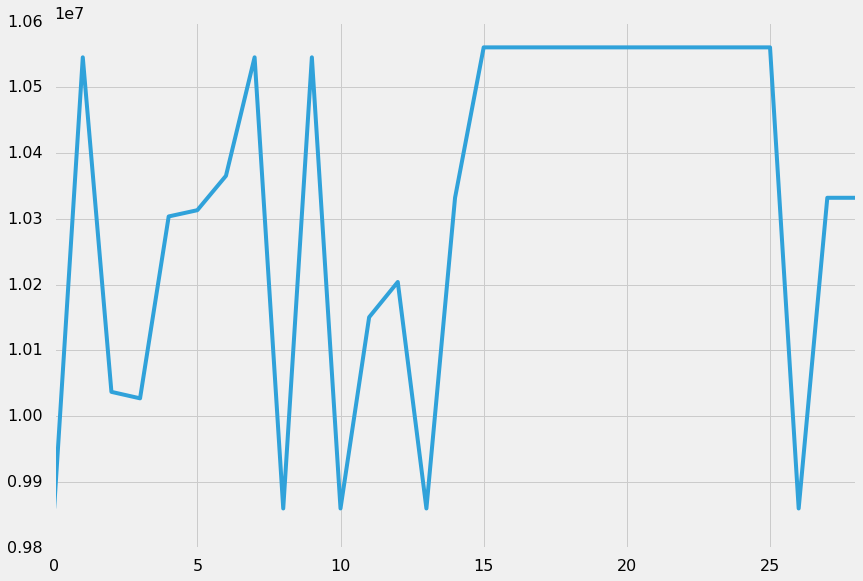

In [131]:
pd.Series([x[2] for x in results]).plot()

In [132]:
[x[2] for x in results]

[9859535.0562031344,
 10545816.781614168,
 10036904.071577815,
 10027063.236628737,
 10303768.207755748,
 10313260.413609516,
 10365591.788532862,
 10545816.781614168,
 9859535.0562031344,
 10545816.781614168,
 9859535.0562031344,
 10150474.930772413,
 10204059.767045012,
 9859535.0562031344,
 10332152.594735747,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 10560964.023968218,
 9859535.0562031344,
 10332152.594735747,
 10332152.594735747]

In [120]:
school[school.threshold>1]

,index,Name,ISP,Enrollment,Identified,LunchPerStudent,BreakfastPerStudent,Lunches,Breakfasts,group,meal,meal/student,threshold,reimburse,trank,msrank
0,32494,YESHIVA DARKEI EMUNAH,0.7878,209,165.0,0.374540,0.031429,14090.0,1182.0,1000,22499.00,107.651,1.014718,22499.00,93.0,9.0
1,30411,USDA-CEO P168X AT PUBLIC SCHOOL 842X,0.400009,1053,421.0,0.950714,0.636410,180198.0,120625.0,1000,472380.85,448.605,1.014718,472380.85,8.0,93.0
2,29648,LANSINGBURGH SENIOR HIGH SCHOOL,0.5443,746,406.0,0.731994,0.314356,98292.0,42212.0,1000,216394.40,290.073,1.014718,216394.40,28.0,50.0
3,30054,IS 7 ELIAS BERNSTEIN,0.684823,394,270.0,0.598658,0.508571,42457.0,36068.0,1000,124681.65,316.451,1.014718,124681.65,76.0,63.0
4,30028,IS 237,0.589691,216,127.0,0.156019,0.907566,6066.0,35286.0,1000,70546.20,326.603,1.014718,70546.20,36.0,67.0
5,29343,SCHOOL 7,0.6299,282,178.0,0.155995,0.249292,7918.0,12654.0,1000,33625.60,119.24,1.014718,33625.60,71.0,11.0
7,29983,ESSENCE SCHOOL,0.624823,58,36.0,0.866176,0.755551,9043.0,7888.0,1000,26916.35,464.075,1.014718,26916.35,46.5,94.0
8,29332,DISCOVERY CHARTER SCHOOL,0.9464,277,262.0,0.601115,0.228798,29972.0,11408.0,1000,63423.40,228.965,1.014718,63423.40,100.0,33.0
9,29885,PUBLIC SCHOOL66 SCHOOL OF HIGHER EXPECTATIONS,0.624823,74,46.0,0.708073,0.076980,9432.0,1025.0,1000,15470.15,209.056,1.014718,15470.15,48.0,31.0
10,28962,WILBUR H LYNCH LITERACY ACADEMY,0.5613,805,452.0,0.020584,0.289751,2983.0,41985.0,1000,77799.10,96.6448,1.014718,77799.10,34.0,7.0


In [74]:
school['trank'] = school['threshold'].rank()
school['msrank'] = school['meal/student'].rank()

In [75]:
school.head()

,index,Name,ISP,Enrollment,Identified,LunchPerStudent,BreakfastPerStudent,Lunches,Breakfasts,group,meal,meal/student,threshold,reimburse,trank,msrank
0,32494,YESHIVA DARKEI EMUNAH,0.7878,209,165.0,0.374540,0.031429,14090.0,1182.0,0,22499.00,107.651,1.263158,22499.000000,93.0,9.0
1,30411,USDA-CEO P168X AT PUBLIC SCHOOL 842X,0.400009,1053,421.0,0.950714,0.636410,180198.0,120625.0,1,472380.85,448.605,0.639696,302180.190465,8.0,93.0
2,29648,LANSINGBURGH SENIOR HIGH SCHOOL,0.5443,746,406.0,0.731994,0.314356,98292.0,42212.0,2,216394.40,290.073,0.870777,188431.370295,28.0,50.0
3,30054,IS 7 ELIAS BERNSTEIN,0.684823,394,270.0,0.598658,0.508571,42457.0,36068.0,3,124681.65,316.451,1.096447,124681.650000,76.0,63.0
4,30028,IS 237,0.589691,216,127.0,0.156019,0.907566,6066.0,35286.0,4,70546.20,326.603,0.940741,66365.684444,36.0,67.0


In [76]:
t0,l0

(0.99294128801346337, 251.74301002631017)

In [87]:
school[school.msrank==40]

,index,Name,ISP,Enrollment,Identified,LunchPerStudent,BreakfastPerStudent,Lunches,Breakfasts,group,meal,meal/student,threshold,reimburse,trank,msrank
14,30221,PARKSIDE PREP ACADEMY,0.400009,30,12.0,0.181825,0.633404,982.0,3420.0,14,7408.9,246.963,0.64,4741.696,10.5,40.0


In [95]:
school[school.trank==48]

,index,Name,ISP,Enrollment,Identified,LunchPerStudent,BreakfastPerStudent,Lunches,Breakfasts,group,meal,meal/student,threshold,reimburse,trank,msrank
9,29885,PUBLIC SCHOOL66 SCHOOL OF HIGHER EXPECTATIONS,0.624823,74,46.0,0.708073,0.07698,9432.0,1025.0,9,15470.15,209.056,0.994595,15386.527568,48.0,31.0
